In [1]:
# Import libraries
import numpy as np
import math
import random
import pandas as pd
import anndata
import scanpy.external as sce  # for harmony_integrate
import harmonypy
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm # linear regression
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scanpy as sc
import os
import SpatialproxseqClasses as SPC


#*****
mpl.rcdefaults()
# Set font to be arial
mpl.rc('font', **{'sans-serif':'Arial', 'size':12})
mpl.rcParams['mathtext.rm'] = 'sans' # to have non-italic greek letter, use r'$\mathrm{\alpha}$', does NOT work with f-string
mpl.rcParams['axes.titlesize'] = 12
# Set default tick size
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['ytick.minor.size'] = 2.5
# Default legend settings
mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.edgecolor'] = 'k'

#to store text as text, not as path
new_rc_params = {'text.usetex': False,
                 "svg.fonttype": 'none'}
mpl.rcParams.update(new_rc_params)
#*****
# Seed number
np.random.seed(2025)
random.seed(2025)

In [2]:
def load_and_preprocess_sample(visium_path, cluster_csv, sample_name):
    # Load Visium data
    adata = sc.read_visium(visium_path)
    adata.var_names_make_unique()

    # Annotate RNA
    adata.obs["mRNA"] = "RNA"

    # Mitochondrial gene QC
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

    # Optional mitochondrial filtering
    # adata = adata[adata.obs["pct_counts_mt"] < 6].copy()

    # UMI filtering
    sc.pp.filter_cells(adata, min_counts=1000)
    sc.pp.filter_genes(adata, min_cells=3)

    # Preserve counts
    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata.copy()
    
  

    # Load external cluster annotation
    cluster_info = pd.read_csv(cluster_csv, index_col=0)
    adata.obs = adata.obs.join(cluster_info)

    # Subset to GC zones
    adata = adata[adata.obs["mrna_annotation"].isin(["Light zone", "Dark zone", "Non-GC follicles"])].copy()

    # Add sample ID for batch correction
    adata.obs["batch"] = sample_name

    return adata


In [3]:
adata_A1 = load_and_preprocess_sample("A1_outs", "A1_adata_mRNA_cell_clusters.csv", "A1")
adata_B1 = load_and_preprocess_sample("B1_outs", "B1_adata_mRNA_cell_clusters.csv", "B1")
adata_D1 = load_and_preprocess_sample("D1_outs", "D1_adata_mRNA_cell_clusters.csv", "D1")


/var/folders/zq/r1fxzh5j34100gjpvnw5chf40000gp/T/ipykernel_91894/832408687.py:3: FutureWarning: Use `squidpy.read.visium` instead.
  adata = sc.read_visium(visium_path)
/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/var/folders/zq/r1fxzh5j34100gjpvnw5chf40000gp/T/ipykernel_91894/832408687.py:3: FutureWarning: Use `squidpy.read.visium` instead.
  adata = sc.read_visium(visium_path)
/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_ma

In [4]:

# Add library_id
adata_A1.obs["library_id"] = "A1"
adata_B1.obs["library_id"] = "B1"
adata_D1.obs["library_id"] = "D1"

adata_A1.obs_names = ["A1_" + name for name in adata_A1.obs_names]
adata_B1.obs_names = ["B1_" + name for name in adata_B1.obs_names]
adata_D1.obs_names = ["D1_" + name for name in adata_D1.obs_names]

# Concatenate
adata = anndata.concat(
    [adata_A1, adata_B1, adata_D1],
    label="batch", keys=["A1", "B1", "D1"],
    index_unique=None
)

# Define function to extract spatial key name
def get_spatial_key(adata):
    return list(adata.uns["spatial"].keys())[0]

# Fix spatial images
adata.uns["spatial"] = {
    "A1": adata_A1.uns["spatial"][get_spatial_key(adata_A1)],
    "B1": adata_B1.uns["spatial"][get_spatial_key(adata_B1)],
    "D1": adata_D1.uns["spatial"][get_spatial_key(adata_D1)],
}


In [5]:
adata.write("combined_GC_follicle_mRNA_ABD.h5ad")

/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
2025-08-13 14:55:06,073 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-08-13 14:55:07,255 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-08-13 14:55:07,275 - harmonypy - INFO - Iteration 1 of 10
2025-08-13 14:55:08,803 - harmonypy - INFO - Iteration 2 of 10
2025-08-13 14:55:10,318 - harmonypy - INFO - Iteration 3 of 10
2025-08-13 14:55:10,863 - harmonypy - INFO - Iteration 4 of 10
2025-08-13 14:55:11,622 - harmonypy - INFO - Iteration 5 of 10
2025-08-13 14:55:11,997 - harmonypy - INFO - Iteration 6 of 10
2025-08-13 14:55:12,443 - harmonypy - INFO - Iteration 7 of 10
2025-08-13 14:55:12,832 - harmonypy - INFO - Converged after 7 iterations
/var/folders/zq/r1fxzh5j34100gjpvnw5chf40000gp/T/ipykernel_91894/4294233035.py:19: FutureWarning: In the future, 

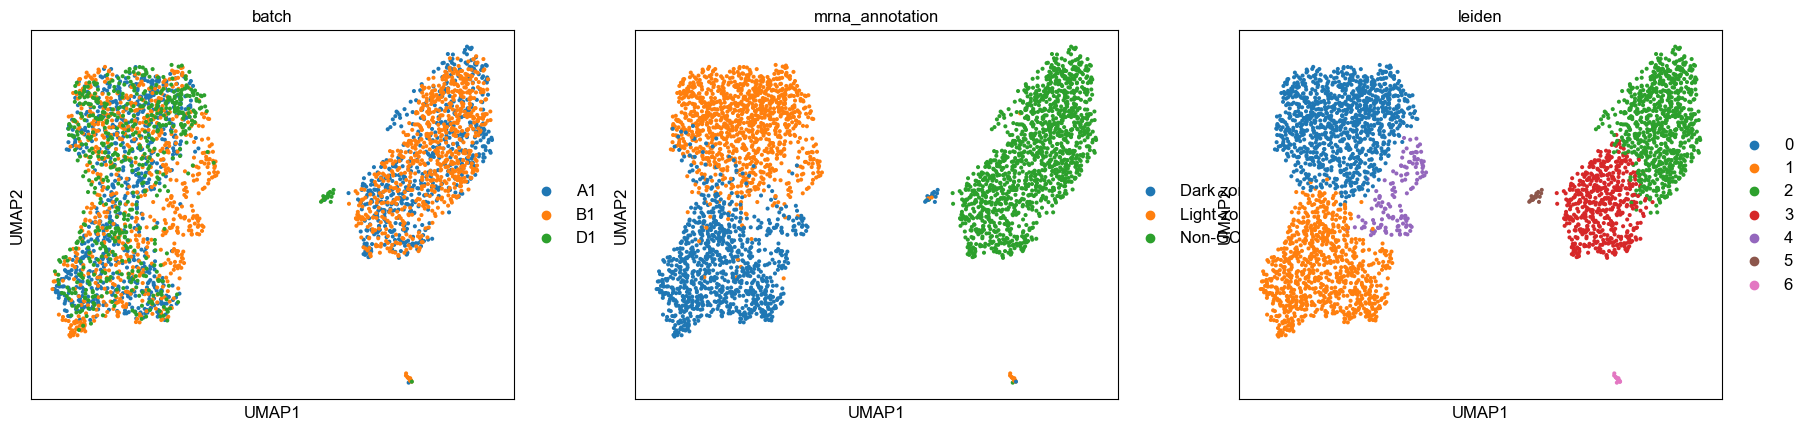

In [6]:
# Highly variable gene selection (by batch)
sc.pp.highly_variable_genes(adata, n_top_genes=4000, batch_key="batch")
adata = adata[:, adata.var["highly_variable"]].copy()
# Step Scaling
sc.pp.scale(adata, max_value=10)

sc.tl.pca(adata, svd_solver='arpack')

# Step 4: Harmony integration to remove batch effect
sce.pp.harmony_integrate(adata, key='batch')

# Step 5: Neighbors & UMAP using Harmony-corrected PCA
sc.pp.neighbors(adata, use_rep='X_pca_harmony', n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)

adata.write("combined_GC_follicle_mRNA_ABD_remove_batch_effect.h5ad")

# Step 6: Clustering (optional)
sc.tl.leiden(adata, resolution=0.5)

# Step 7: Plot (optional)
sc.pl.umap(adata, color=["batch", "mrna_annotation", "leiden"])


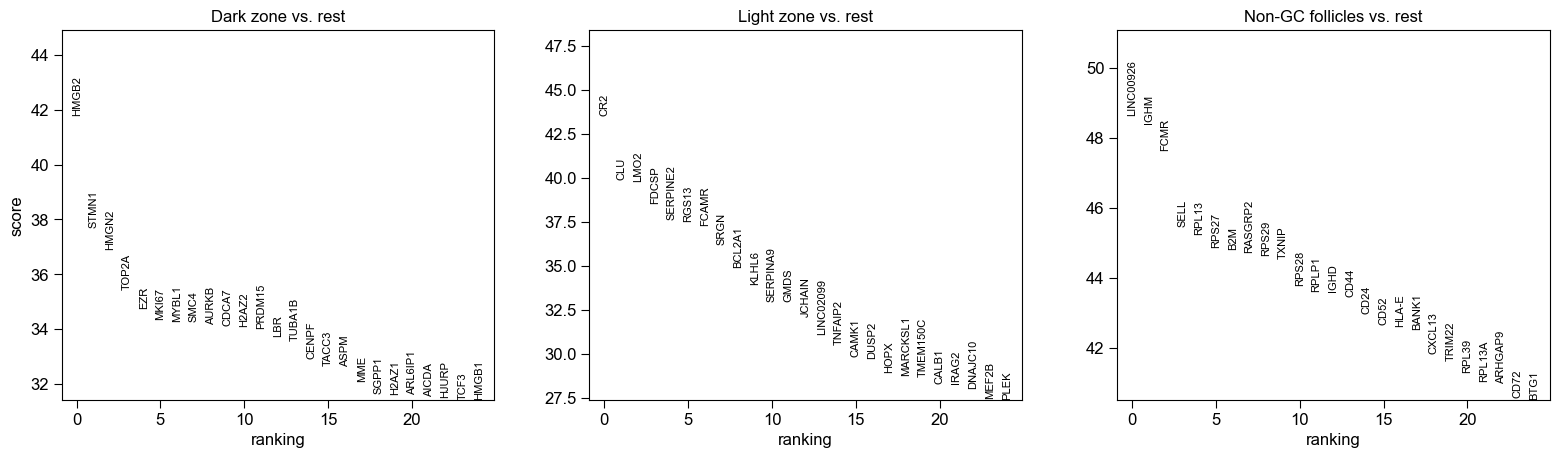

In [7]:
sc.tl.rank_genes_groups(adata, groupby="mrna_annotation", method="wilcoxon", )
sc.pl.rank_genes_groups(adata, groupby="mrna_annotation", n_genes=25, sharey=False)

In [8]:
# Function to set spatial image and scalefactor metadata
def set_uns_parameters(adata, library_id, image, scalefactors):
    spatial_key = "spatial"
    adata.uns[spatial_key] = {
        library_id: {
            "images": {"hires": image},
            "scalefactors": scalefactors
        }
    }

# Sample metadata for all four samples
samples = {
    "A1": {
        "matrix": "A1-PLA_count_matrix.txt.gz",
        "barcode": "A1_outs/spatial/tissue_positions.csv",
        "image": "A1_outs/spatial/tissue_hires_image.png",
        "scalefactors": {'tissue_hires_scalef': 0.5177323,
                         'tissue_lowres_scalef': 0.1553197,
                         'fiducial_diameter_fullres': 45.467644,
                         'spot_diameter_fullres': 28.146637

        }
    },
    "B1": {
        "matrix": "B1-PLA_count_matrix.txt.gz",
        "barcode": "B1_outs/spatial/tissue_positions.csv",
        "image": "B1_outs/spatial/tissue_hires_image.png",
        "scalefactors": {
            'tissue_hires_scalef': 0.53748995,
            'tissue_lowres_scalef': 0.16124697,
            'fiducial_diameter_fullres': 45.46590400000001,
            'spot_diameter_fullres': 28.145561000000004
        }
    },

    "D1": {
        "matrix": "D1-PLA_count_matrix.txt.gz",
        "barcode": "D1_outs/spatial/tissue_positions.csv",
        "image": "D1_outs/spatial/tissue_hires_image.png",
        "scalefactors": {
            'tissue_hires_scalef': 0.53590566,
            'tissue_lowres_scalef': 0.1607717,
            'fiducial_diameter_fullres': 45.420517,
            'spot_diameter_fullres': 28.117462
        }
    }
}
# Output dictionaries
adata_pla_dict = {}
adata_protein_dict = {}
adata_protein_pair_dict = {}


# Loop over samples
for sid, info in samples.items():
    print(f"Processing sample: {sid}")

    # Load raw data
    data = pd.read_csv(info["matrix"], sep="\t", index_col=0)

    # Fix probe names
    data.index = data.index.str.replace(r"^VCAM1_B:(.*)$", r"CD40_A:\1", regex=True)
    data.index = data.index.str.replace(r"^CD29_B:(.*)$", r"CD279_A:\1", regex=True)
    data.index = data.index.str.replace(r"^LFA1_B:(.*)$", r"CD11a_A:\1", regex=True)

    # Filter & clean PLA
    valid_condition = ~data.index.str.contains(r'((:.*_A)|(_B:))', regex=True)
    pla = data[valid_condition]
    pla.index = pla.index.str.replace(r'(_A|_B)', '', regex=True)
    pla = pla.loc[~pla.index.str.contains("HLADPRQ"), :]

    # Build PLA object  
    pla_obj = SPC.sproxseqObject(pla)
    pla_obj.compute_protein_pair_counts()
    pla_obj.compute_protein_abundance()


    # Load spatial info
    tissue_barcode = pd.read_csv(info["barcode"]).set_index("barcode")
    tissue_barcode = tissue_barcode.loc[pla.transpose().index, :]
    spatial = tissue_barcode[["pxl_col_in_fullres", "pxl_row_in_fullres"]].to_numpy()
    obs = tissue_barcode[["in_tissue", "array_row", "array_col"]]

    # Create AnnData objects
    adata_pla = sc.AnnData(pla.transpose().to_numpy(), obsm={"spatial": spatial}, obs=obs.copy())
    adata_protein = sc.AnnData(pla_obj.protein_count.transpose().to_numpy(), obsm={"spatial": spatial}, obs=obs.copy())
    adata_protein_pair = sc.AnnData(pla_obj.protein_pair_count.transpose().to_numpy(), obsm={"spatial": spatial}, obs=obs.copy())
  
    # Add batch
    for ad in [adata_pla, adata_protein, adata_protein_pair, ]:
        ad.obs["batch"] = sid

    # Assign var names
    adata_pla.var.index = pla.index
    adata_protein.var.index = pla_obj.protein_count.index
    adata_protein_pair.var.index = pla_obj.protein_pair_count.index


    # Set spatial metadata
    image = mpimg.imread(info["image"])
    library_id = f"{sid}_Human_tonsil_Proxseq"
    for ad in [adata_pla, adata_protein, adata_protein_pair, ]:
        set_uns_parameters(ad, library_id, image, info["scalefactors"])

    # Normalize & log
    for ad, tag, ftype in zip([adata_protein, adata_protein_pair], ["protein", "protein_pair"], ["protein", "protein_pair"]):
        ad.var["IgG"] = ad.var_names.str.contains("IgG1a")
        ad.var["feature_types"] = ftype
        ad.layers["counts"] = ad.X.copy()
        sc.pp.normalize_total(ad, target_sum=1e4)
        sc.pp.log1p(ad)
        ad.raw = ad.copy()

    # 👉 Load cluster info HERE
    cluster_csv = f"{sid}_adata_mRNA_cell_clusters.csv"  # you provide this file
    cluster_info = pd.read_csv(cluster_csv, index_col=0)

    # 👉 Join and subset for protein and protein_pair
    for ad in [adata_protein, adata_protein_pair]:
        ad.obs = ad.obs.join(cluster_info)
        ad._inplace_subset_obs(ad.obs["mrna_annotation"].isin(["Light zone", "Dark zone", "Non-GC follicles"]))

    # Save
    adata_pla_dict[sid] = adata_pla
    adata_protein_dict[sid] = adata_protein
    adata_protein_pair_dict[sid] = adata_protein_pair

print("✅ All samples loaded & subset to LZ/DZ successfully.")


Processing sample: A1


/var/folders/zq/r1fxzh5j34100gjpvnw5chf40000gp/T/ipykernel_91894/2558492918.py:67: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  valid_condition = ~data.index.str.contains(r'((:.*_A)|(_B:))', regex=True)


Processing sample: B1


/var/folders/zq/r1fxzh5j34100gjpvnw5chf40000gp/T/ipykernel_91894/2558492918.py:67: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  valid_condition = ~data.index.str.contains(r'((:.*_A)|(_B:))', regex=True)


Processing sample: D1


/var/folders/zq/r1fxzh5j34100gjpvnw5chf40000gp/T/ipykernel_91894/2558492918.py:67: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  valid_condition = ~data.index.str.contains(r'((:.*_A)|(_B:))', regex=True)


✅ All samples loaded & subset to LZ/DZ successfully.


In [9]:

adata_protein_A1 = adata_protein_dict["A1"]
adata_protein_B1 = adata_protein_dict["B1"]
adata_protein_D1 = adata_protein_dict["D1"]

# Add library_id
adata_protein_A1.obs["library_id"] = "A1"
adata_protein_B1.obs["library_id"] = "B1"
adata_protein_D1.obs["library_id"] = "D1"

adata_protein_A1.obs_names = ["A1_" + name for name in adata_protein_A1.obs_names]
adata_protein_B1.obs_names = ["B1_" + name for name in adata_protein_B1.obs_names]
adata_protein_D1.obs_names = ["D1_" + name for name in adata_protein_D1.obs_names]

# Concatenate
adata_protein_all = anndata.concat(
    [adata_protein_A1, adata_protein_B1, adata_protein_D1],
    label="batch", keys=["A1", "B1", "D1"],
    index_unique=None
)

# Define function to extract spatial key name
def get_spatial_key(adata_protein_all):
    return list(adata_protein_all.uns["spatial"].keys())[0]

# Fix spatial images
adata_protein_all.uns["spatial"] = {
    "A1": adata_protein_A1.uns["spatial"][get_spatial_key(adata_protein_A1)],
    "B1": adata_protein_B1.uns["spatial"][get_spatial_key(adata_protein_B1)],
    "D1": adata_protein_D1.uns["spatial"][get_spatial_key(adata_protein_D1)],
}


In [10]:
adata_protein_all.write("combined_GC_follicle_protein_ABD.h5ad")


In [11]:
adata_protein_pair_A1 = adata_protein_pair_dict["A1"]
adata_protein_pair_B1 = adata_protein_pair_dict["B1"]
adata_protein_pair_D1 = adata_protein_pair_dict["D1"]


# Add library_id
adata_protein_pair_A1.obs["library_id"] = "A1"
adata_protein_pair_B1.obs["library_id"] = "B1"
adata_protein_pair_D1.obs["library_id"] = "D1"

adata_protein_pair_A1.obs_names = ["A1_" + name for name in adata_protein_pair_A1.obs_names]
adata_protein_pair_B1.obs_names = ["B1_" + name for name in adata_protein_pair_B1.obs_names]
adata_protein_pair_D1.obs_names = ["D1_" + name for name in adata_protein_pair_D1.obs_names]

# Concatenate
adata_protein_pair_all = anndata.concat(
    [adata_protein_pair_A1, adata_protein_pair_B1, adata_protein_pair_D1],
    label="batch", keys=["A1", "B1", "D1"],
    index_unique=None
)

# Define function to extract spatial key name
def get_spatial_key(adata_protein_pair_all):
    return list(adata_protein_pair_all.uns["spatial"].keys())[0]

# Fix spatial images
adata_protein_pair_all.uns["spatial"] = {
    "A1": adata_protein_pair_A1.uns["spatial"][get_spatial_key(adata_protein_pair_A1)],
    "B1": adata_protein_pair_B1.uns["spatial"][get_spatial_key(adata_protein_pair_B1)],
    "D1": adata_protein_pair_D1.uns["spatial"][get_spatial_key(adata_protein_pair_D1)],
}


In [12]:
adata_protein_pair_all.write("combined_GC_follicle_protein_pair_ABD.h5ad")

2025-08-13 14:56:25,978 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-08-13 14:56:29,694 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-08-13 14:56:29,733 - harmonypy - INFO - Iteration 1 of 10
2025-08-13 14:56:31,052 - harmonypy - INFO - Iteration 2 of 10
2025-08-13 14:56:32,727 - harmonypy - INFO - Iteration 3 of 10
2025-08-13 14:56:34,098 - harmonypy - INFO - Converged after 3 iterations


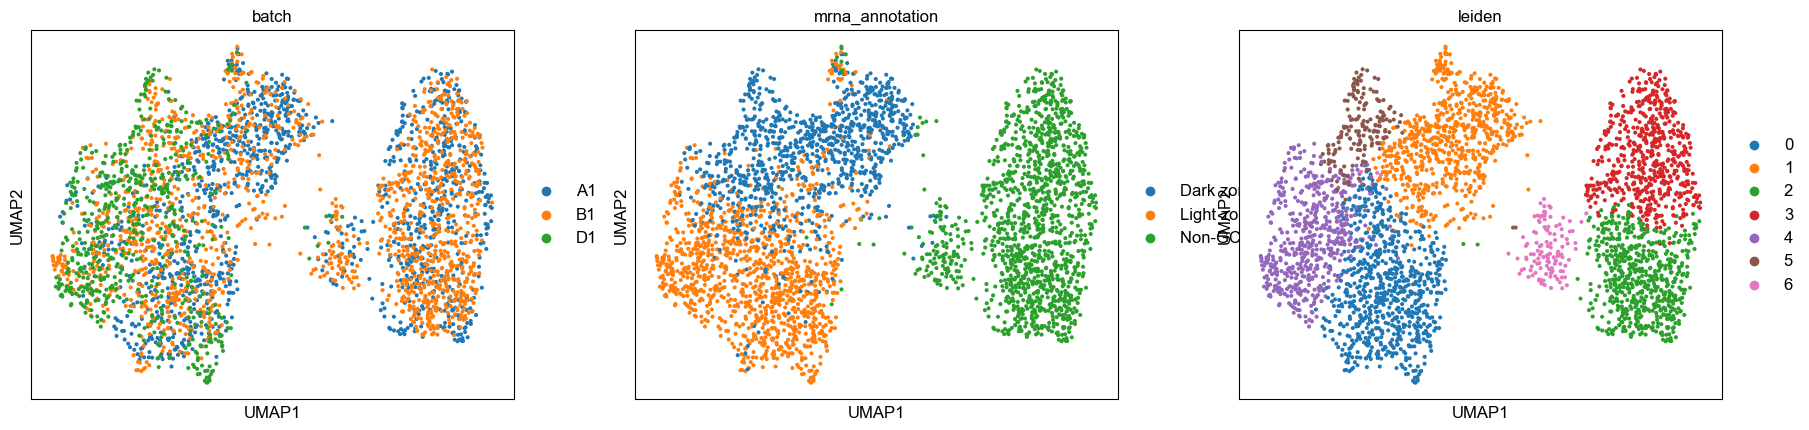

In [13]:
# Step 3: PCA
sc.pp.scale(adata_protein_pair_all, max_value=10)
sc.tl.pca(adata_protein_pair_all, svd_solver='arpack')

# Step 4: Harmony integration to remove batch effect
sce.pp.harmony_integrate(adata_protein_pair_all, key='batch')

# Step 5: Neighbors & UMAP
sc.pp.neighbors(adata_protein_pair_all, use_rep='X_pca_harmony', n_neighbors=10, n_pcs=30)
sc.tl.umap(adata_protein_pair_all)
adata_protein_pair_all.write("combined_GC_follicle_protein_pair_ABD_remove_batch_effect.h5ad")


# Step 6: Clustering
sc.tl.leiden(adata_protein_pair_all, resolution=0.5)

# Step 7: Visualization
sc.pl.umap(adata_protein_pair_all, color=["batch", "mrna_annotation", "leiden"])


In [14]:
# Step 3: PCA
sc.pp.scale(adata_protein_all, max_value=10)
sc.tl.pca(adata_protein_all, svd_solver='arpack')

# Step 4: Harmony integration to remove batch effect
sce.pp.harmony_integrate(adata_protein_all, key='batch')

# Step 5: Neighbors & UMAP
sc.pp.neighbors(adata_protein_all, use_rep='X_pca_harmony', n_neighbors=10, n_pcs=30)
sc.tl.umap(adata_protein_all)
adata_protein_all.write("combined_GC_follicle_protein_ABD_remove_batch_effect.h5ad")


# Step 6: Clustering
sc.tl.leiden(adata_protein_all, resolution=0.5)



2025-08-13 14:56:37,612 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-08-13 14:56:40,834 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-08-13 14:56:40,876 - harmonypy - INFO - Iteration 1 of 10
2025-08-13 14:56:42,607 - harmonypy - INFO - Iteration 2 of 10
2025-08-13 14:56:45,444 - harmonypy - INFO - Iteration 3 of 10
2025-08-13 14:56:46,394 - harmonypy - INFO - Iteration 4 of 10
2025-08-13 14:56:47,426 - harmonypy - INFO - Converged after 4 iterations


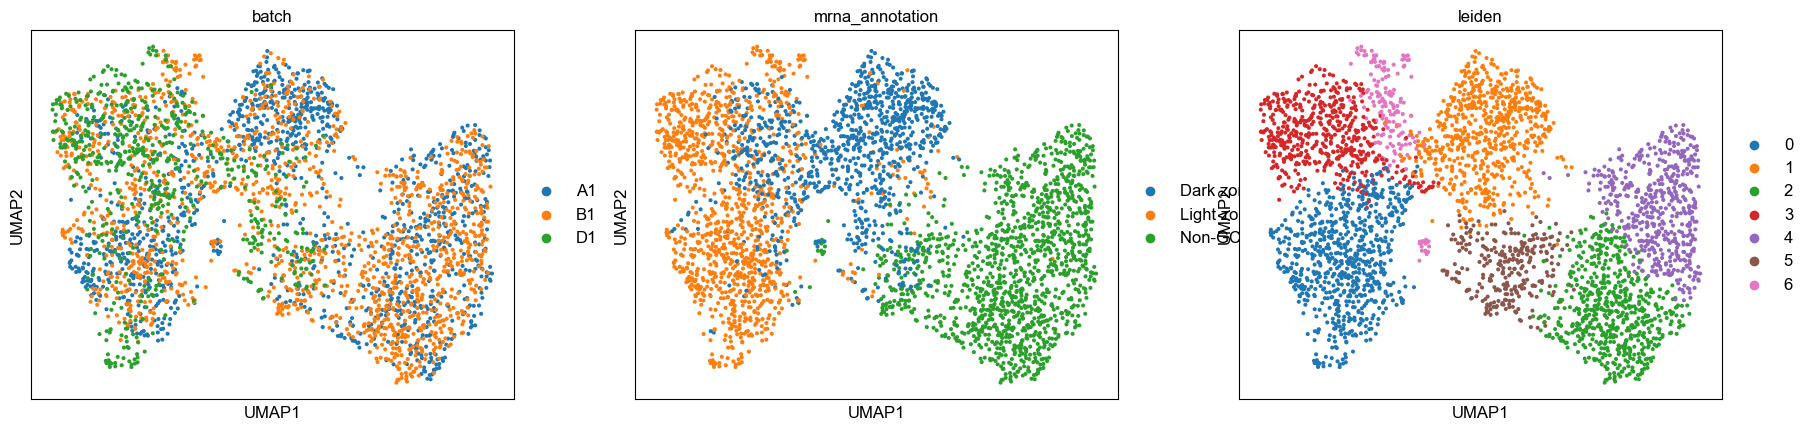

In [15]:
# Step 7: Visualization
sc.pl.umap(adata_protein_all, color=["batch", "mrna_annotation", "leiden"],)


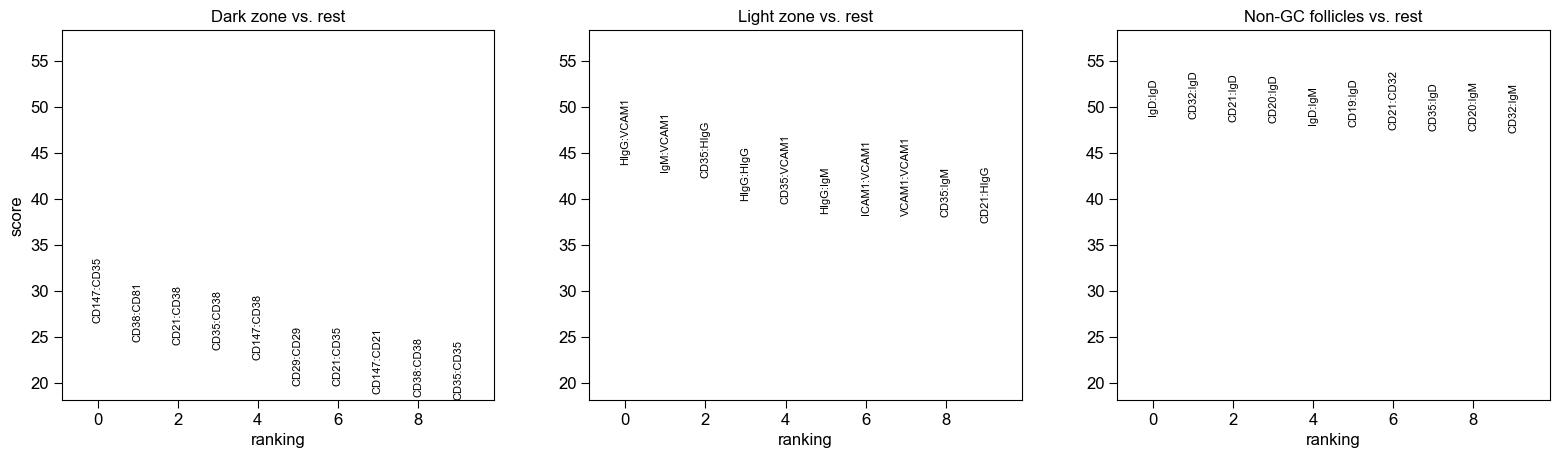

In [17]:
sc.tl.rank_genes_groups(adata_protein_pair_all, groupby='mrna_annotation', method='wilcoxon')
sc.pl.rank_genes_groups(adata_protein_pair_all, n_genes=10)


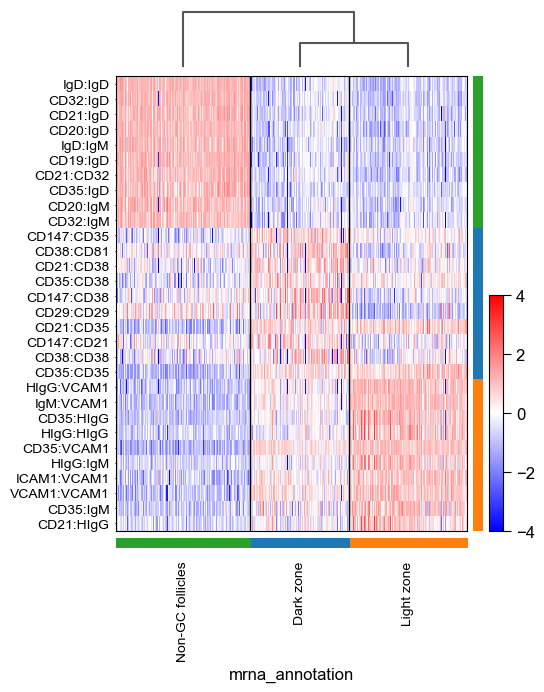

In [18]:
sc.pl.rank_genes_groups_heatmap(adata_protein_pair_all, n_genes=10, groupby='mrna_annotation', swap_axes=True, use_raw=False, vmin=-4, vmax=4,
                                cmap='bwr', figsize=(5, 7))

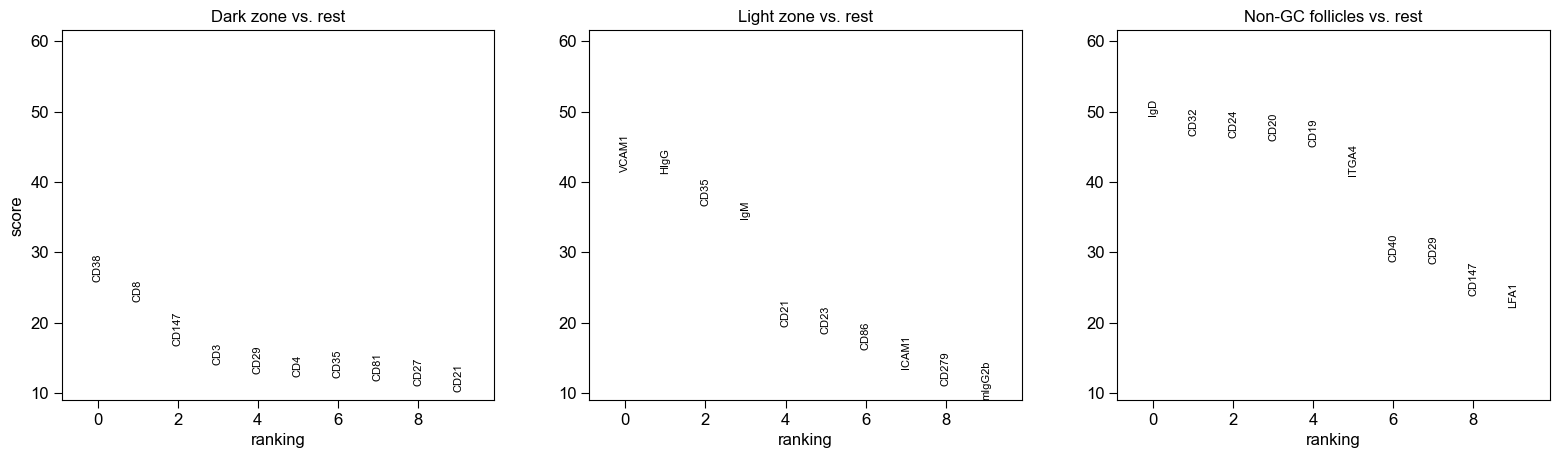

In [19]:
sc.tl.rank_genes_groups(adata_protein_all, groupby='mrna_annotation', method='wilcoxon')
sc.pl.rank_genes_groups(adata_protein_all, n_genes=10)

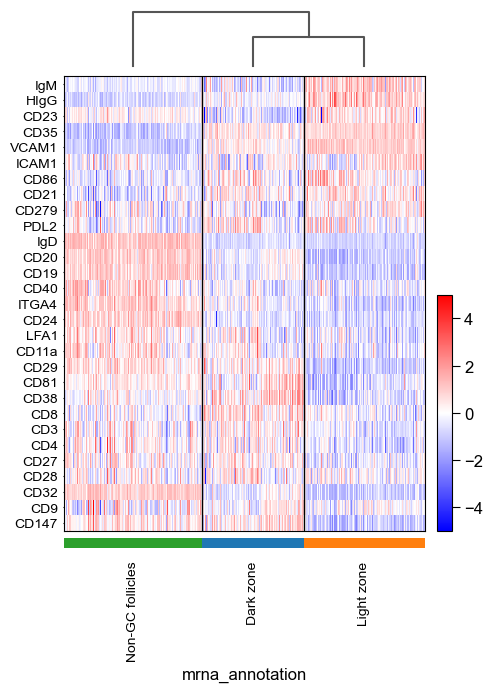

In [20]:
custom_protein_order = [  'IgM','HIgG','CD23', 'CD35', 'VCAM1','ICAM1', 'CD86', 'CD21',  'CD279','PDL2','IgD', 'CD20', 'CD19',  'CD40', 'ITGA4', 'CD24', 'LFA1','CD11a',
    'CD29','CD81','CD38', 'CD8',  'CD3',  'CD4','CD27','CD28', 'CD32','CD9', 'CD147',]

sc.pl.rank_genes_groups_heatmap(adata_protein_all,var_names=custom_protein_order, groupby='mrna_annotation', swap_axes=True, use_raw=False, vmin=-5, vmax=5,
                                cmap='bwr', figsize=(5, 7))

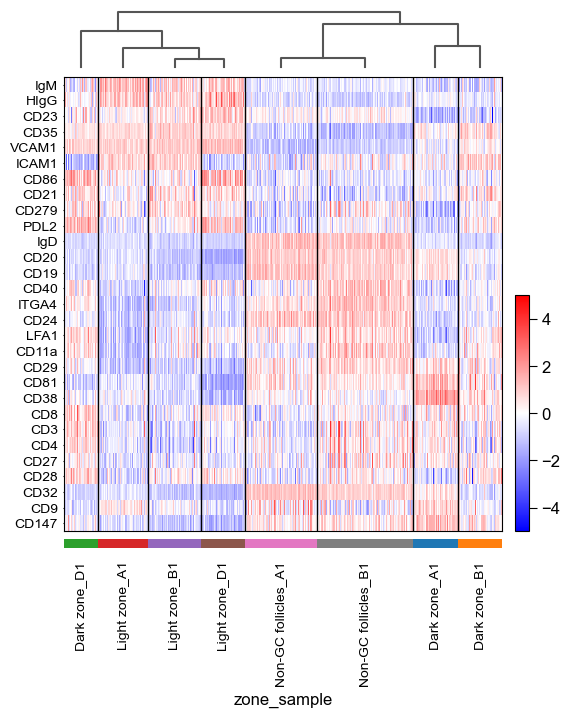

In [21]:
# Step 1: Combine zone and batch/sample information into one label
adata_protein_all.obs["zone_sample"] = (
    adata_protein_all.obs["mrna_annotation"].astype(str) + "_" + 
    adata_protein_all.obs["batch"].astype(str)
)

# Step 2: Plot the heatmap with the combined annotation
sc.pl.rank_genes_groups_heatmap(
    adata_protein_all,
    var_names=custom_protein_order,       # your predefined list of proteins
    groupby="zone_sample",                # combined zone and batch info
    swap_axes=True,                       # so genes are on y-axis
    use_raw=False,
    vmin=-5, vmax=5,
    cmap="bwr",
    figsize=(6, 7)
)


In [22]:
def load_fraction_data(sample_name, matrix_file, barcode_file, image_file, scalefactors, cluster_csv):
    """
    Load pre-normalized PLA fraction matrix for one sample into AnnData with spatial metadata.
    Filters to only include Light zone, Dark zone, Primary follicle regions.

    Parameters:
    - sample_name: str, sample ID (e.g., 'A1')
    - matrix_file: str, path to PLA fraction CSV (rows: features, columns: barcodes)
    - barcode_file: str, Visium tissue_positions.csv
    - image_file: str, path to hires image PNG
    - scalefactors: dict, spatial scale metadata
    - cluster_csv: str, path to cluster annotation CSV with 'mrna_annotation'

    Returns:
    - AnnData object with spatial + fraction data (subset to LZ/DZ/PF)
    """

    # Load matrix
    frac_df = pd.read_csv(matrix_file, index_col=0)

    # Load spatial metadata
    tissue_barcode = pd.read_csv(barcode_file, header=None, index_col=0)
    tissue_barcode.columns = ["in_tissue", "array_row", "array_col", "pxl_row_in_fullres", "pxl_col_in_fullres"]
    tissue_barcode = tissue_barcode.loc[frac_df.columns, :]

    # Load cluster info
    cluster_info = pd.read_csv(cluster_csv, index_col=0)
    
    # Merge cluster info
    obs = tissue_barcode[["in_tissue", "array_row", "array_col"]].copy()
    obs = obs.join(cluster_info)

    # Subset to desired regions
    valid_regions = ["Light zone", "Dark zone", "Non-GC follicles"]
    obs = obs[obs["mrna_annotation"].isin(valid_regions)]
    kept_barcodes = obs.index

    # Filter matrix to match subset
    frac_df = frac_df[kept_barcodes]
    # spatial = tissue_barcode.loc[kept_barcodes, ["pxl_col_in_fullres", "pxl_row_in_fullres"]].to_numpy()
    spatial = tissue_barcode.loc[kept_barcodes, ["pxl_col_in_fullres", "pxl_row_in_fullres"]].astype(float).to_numpy()


    # Build AnnData
    adata = sc.AnnData(
        X=frac_df.transpose().to_numpy(),
        obs=obs,
        obsm={"spatial": spatial}
    )
    adata.var_names = frac_df.index
    adata.obs["batch"] = sample_name
    adata.raw = adata.copy()


    # Set spatial image + scale
    image = mpimg.imread(image_file)
    library_id = f"{sample_name}_Human_tonsil_Proxseq"
    adata.uns["spatial"] = {
        library_id: {
            "images": {"hires": image},
            "scalefactors": scalefactors
        }
    }

    return adata


In [23]:
sample_meta = {
    "A1": {
        "matrix_file": "A1_weighted_sc_pla.csv",
        "barcode_file": "A1_outs/spatial/tissue_positions.csv",
        "image_file": "A1_outs/spatial/tissue_hires_image.png",
        "scalefactors": {
          'tissue_hires_scalef': 0.5177323,
          'tissue_lowres_scalef': 0.1553197,
          'fiducial_diameter_fullres': 45.467644,
          'spot_diameter_fullres': 28.146637
        },
        "cluster_csv": "A1_adata_mRNA_cell_clusters.csv"
    },
    "B1": {
        "matrix_file": "B1_weighted_sc_pla.csv",
        "barcode_file": "B1_outs/spatial/tissue_positions.csv",
        "image_file": "B1_outs/spatial/tissue_hires_image.png",
        "scalefactors": {
           'tissue_hires_scalef': 0.53748995,
            'tissue_lowres_scalef': 0.16124697,
            'fiducial_diameter_fullres': 45.46590400000001,
            'spot_diameter_fullres': 28.145561000000004
        },
        "cluster_csv": "B1_adata_mRNA_cell_clusters.csv"
    },
    "D1": {
        "matrix_file": "D1_weighted_sc_pla.csv",
        "barcode_file": "D1_outs/spatial/tissue_positions.csv",
        "image_file": "D1_outs/spatial/tissue_hires_image.png",
        "scalefactors": {
            'tissue_hires_scalef': 0.53590566,
            'tissue_lowres_scalef': 0.1607717,
            'fiducial_diameter_fullres': 45.420517,
            'spot_diameter_fullres': 28.117462
        },
        "cluster_csv": "D1_adata_mRNA_cell_clusters.csv"
    }
}


In [24]:
# Store loaded AnnData objects and mapping for later spatial fix
fraction_adatas = []
sample_to_adata = {}

# Load and prepare each sample
for sample_id, meta in sample_meta.items():
    print(f"Loading sample {sample_id}...")
    adata = load_fraction_data(
        sample_name=sample_id,
        matrix_file=meta["matrix_file"],
        barcode_file=meta["barcode_file"],
        image_file=meta["image_file"],
        scalefactors=meta["scalefactors"],
        cluster_csv=meta["cluster_csv"]
    )
    
    # Add library_id to obs
    adata.obs["library_id"] = sample_id
    
    # 🔁 Prefix obs_names with sample_id to ensure uniqueness
    adata.obs_names = [f"{sample_id}_{name}" for name in adata.obs_names]
    
    # Sanity check: make sure it's unique
    assert adata.obs_names.is_unique, f"obs_names not unique in {sample_id}!"
    
    # Save
    fraction_adatas.append(adata)
    sample_to_adata[sample_id] = adata

# Merge all samples into one AnnData
adata_fraction_all = anndata.concat(
    fraction_adatas,
    join="outer",
    label="batch",
    keys=sample_meta.keys(),  # will label obs["batch"]
    index_unique=None  # we already made index unique
)

# Helper to extract spatial key name from .uns["spatial"]
def get_spatial_key(adata):
    return list(adata.uns["spatial"].keys())[0]

# Fix .uns["spatial"] to have keys = sample IDs (A1, B1, D1)
adata_fraction_all.uns["spatial"] = {
    sid: sample_to_adata[sid].uns["spatial"][get_spatial_key(sample_to_adata[sid])]
    for sid in sample_meta.keys()
}

# Save to file
adata_fraction_all.write("combined_weighted_fraction_ABD_data.h5ad")
print("✅ All samples loaded, merged, and spatial keys normalized.")


Loading sample A1...
Loading sample B1...
Loading sample D1...
✅ All samples loaded, merged, and spatial keys normalized.


In [25]:
sc.pp.scale(adata_fraction_all, max_value=10)
sc.tl.pca(adata_fraction_all, svd_solver='arpack')
sce.pp.harmony_integrate(adata_fraction_all, key='batch')
sc.pp.neighbors(adata_fraction_all, use_rep='X_pca_harmony', n_neighbors=10, n_pcs=30)
sc.tl.umap(adata_fraction_all)
adata_fraction_all.write("combined_weighted_fraction_ABD_data_remove_batch_effect.h5ad")

sc.tl.leiden(adata_fraction_all, resolution=0.4)

2025-08-13 14:56:54,755 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-08-13 14:56:57,964 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-08-13 14:56:57,994 - harmonypy - INFO - Iteration 1 of 10
2025-08-13 14:56:59,758 - harmonypy - INFO - Iteration 2 of 10
2025-08-13 14:57:01,267 - harmonypy - INFO - Iteration 3 of 10
2025-08-13 14:57:02,466 - harmonypy - INFO - Iteration 4 of 10
2025-08-13 14:57:03,750 - harmonypy - INFO - Iteration 5 of 10
2025-08-13 14:57:05,114 - harmonypy - INFO - Iteration 6 of 10
2025-08-13 14:57:06,830 - harmonypy - INFO - Iteration 7 of 10
2025-08-13 14:57:07,960 - harmonypy - INFO - Iteration 8 of 10
2025-08-13 14:57:08,546 - harmonypy - INFO - Iteration 9 of 10
2025-08-13 14:57:09,251 - harmonypy - INFO - Iteration 10 of 10
2025-08-13 14:57:11,359 - harmonypy - INFO - Stopped before convergence


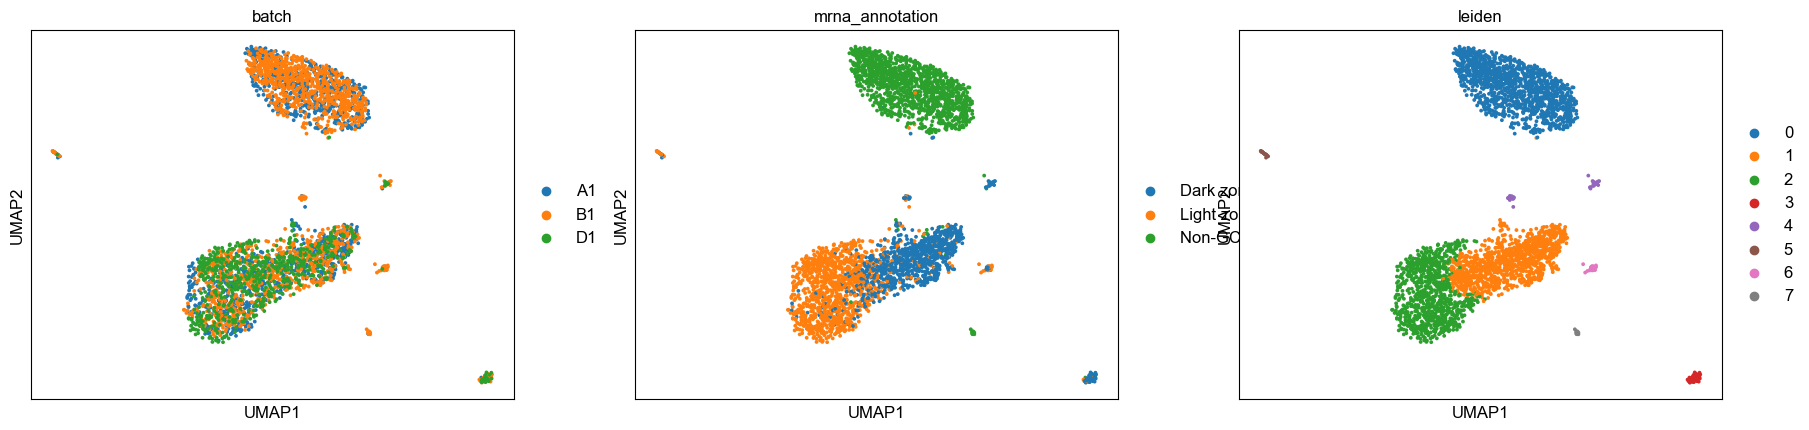

In [26]:
# Visualize clusters and region labels
sc.pl.umap(adata_fraction_all, color=["batch", "mrna_annotation", "leiden"], size=30)

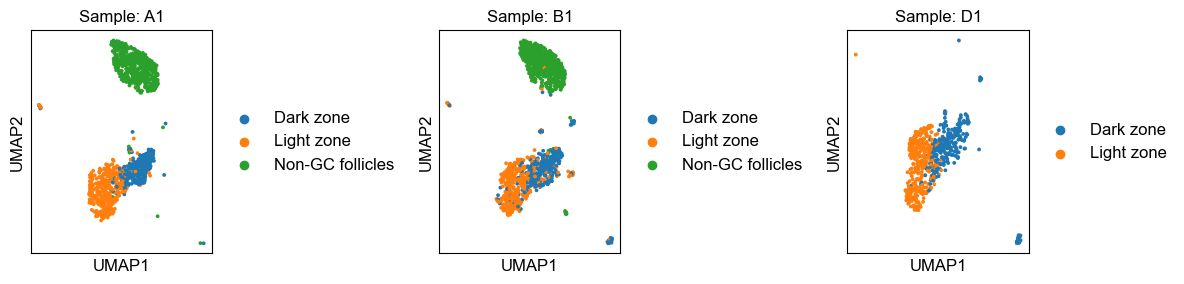

In [27]:
# Get unique batch names
batches = adata_fraction_all.obs["batch"].unique()

# Create one row with len(batches) subplots
fig, axes = plt.subplots(1, len(batches), figsize=(4 * len(batches), 3))  # wider total width

# If there's only one subplot, wrap it in a list to make indexing consistent
if len(batches) == 1:
    axes = [axes]

# Plot one UMAP per batch
for ax, batch in zip(axes, batches):
    sc.pl.umap(
        adata_fraction_all[adata_fraction_all.obs["batch"] == batch],
        color="mrna_annotation",
        title=f"Sample: {batch}",
        size=30,
        ax=ax,
        show=False
    )

plt.tight_layout()
plt.show()


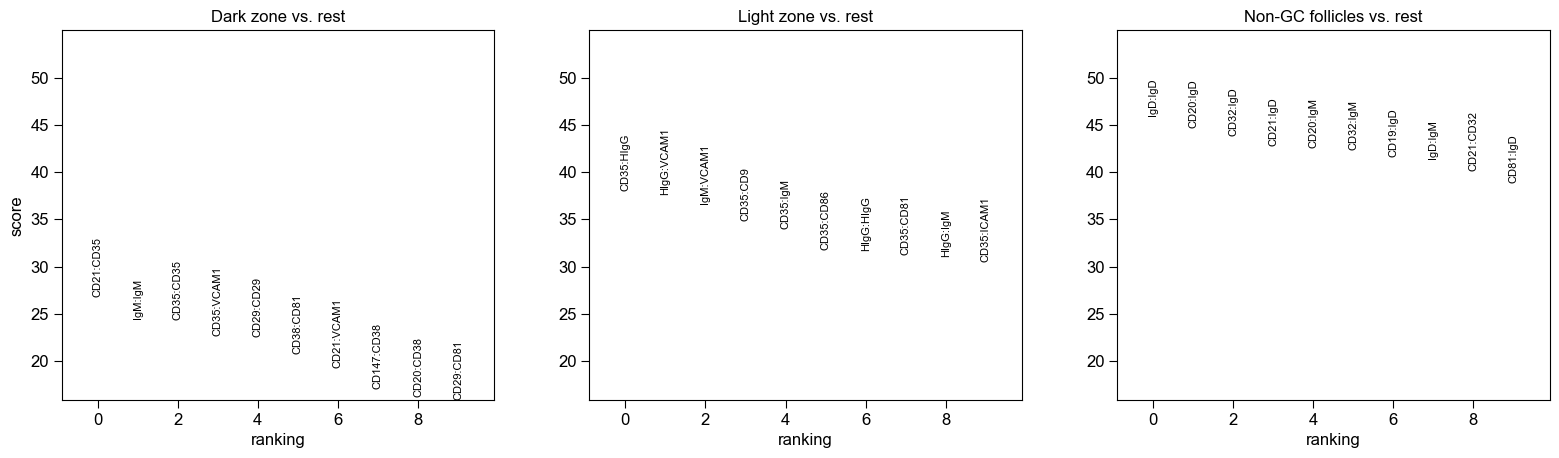

In [28]:
sc.tl.rank_genes_groups(adata_fraction_all, groupby='mrna_annotation', method='wilcoxon')
sc.pl.rank_genes_groups(adata_fraction_all, n_genes=10)


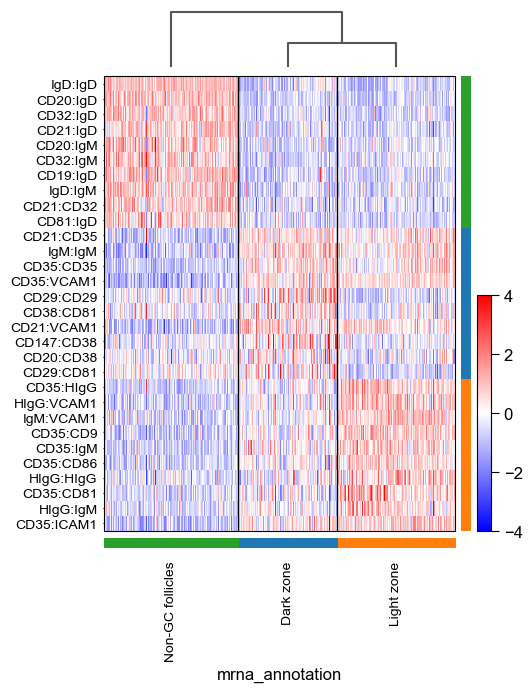

In [29]:
sc.pl.rank_genes_groups_heatmap(adata_fraction_all, n_genes=10, groupby='mrna_annotation', swap_axes=True, use_raw=False, vmin=-4, vmax=4,
                                cmap='bwr', figsize=(5, 7))

categories: Dark zone_A1, Dark zone_B1, Dark zone_D1, etc.
var_group_labels: Dark zone, Light zone, Non-GC follicles


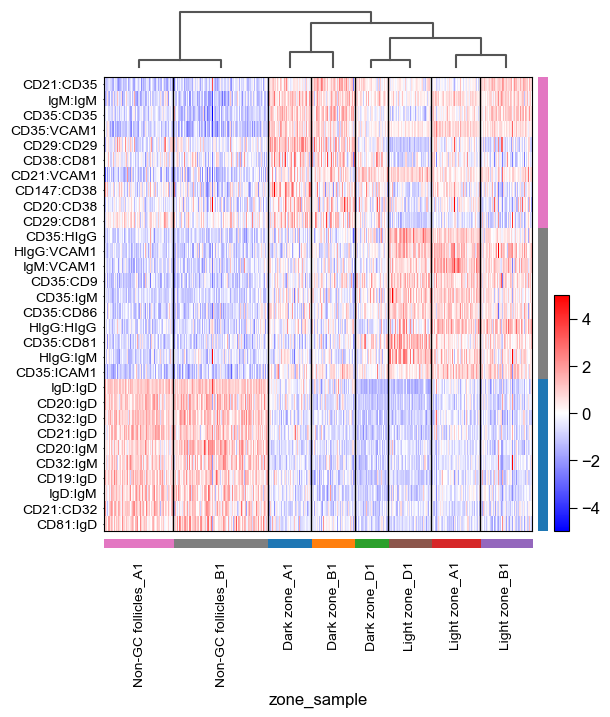

In [30]:
# Step 1: Combine zone and batch/sample information into one label
adata_fraction_all.obs["zone_sample"] = (
    adata_fraction_all.obs["mrna_annotation"].astype(str) + "_" + 
    adata_fraction_all.obs["batch"].astype(str)
)

# Step 2: Plot the heatmap with the combined annotation
sc.pl.rank_genes_groups_heatmap(
    adata_fraction_all,
    n_genes=10,      # your predefined list of proteins
    groupby="zone_sample",                # combined zone and batch info
    swap_axes=True,                       # so genes are on y-axis
    use_raw=False,
    vmin=-5, vmax=5,
    cmap="bwr",
    figsize=(6, 7)
)
